In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
raw_power_data = pd.read_excel("./data_tapo-p115-sct-sd/Power.xls")
raw_power_data = raw_power_data.rename(columns={raw_power_data.columns[0]: 'Date'})
raw_power_data[raw_power_data.columns[0]] = pd.to_datetime(raw_power_data[raw_power_data.columns[0]])
# Convert to numeric and drop rows that can't be converted
raw_power_data = raw_power_data[pd.to_numeric(raw_power_data['Power(W)'], errors='coerce').notna()]
raw_power_data['Power(W)'] = pd.to_numeric(raw_power_data['Power(W)'])
raw_power_data["Energy(kWh)"] = raw_power_data['Power(W)'] / 1000 * (raw_power_data['Date'].diff().dt.total_seconds() / 3600)
raw_power_data.columns

Index(['Date', 'Power(W)', 'Energy(kWh)'], dtype='object')

In [3]:
raw_power_data.describe()

,Date,Power(W),Energy(kWh)
count,289,289.000000,288.000000
mean,2025-08-26 01:40:00,239.525952,0.019971
min,2025-08-25 13:40:00,167.000000,0.013917
25%,2025-08-25 19:40:00,200.000000,0.016667
50%,2025-08-26 01:40:00,203.000000,0.016917
75%,2025-08-26 07:40:00,222.000000,0.018500
max,2025-08-26 13:40:00,773.000000,0.064417
std,NaN,94.219676,0.007863


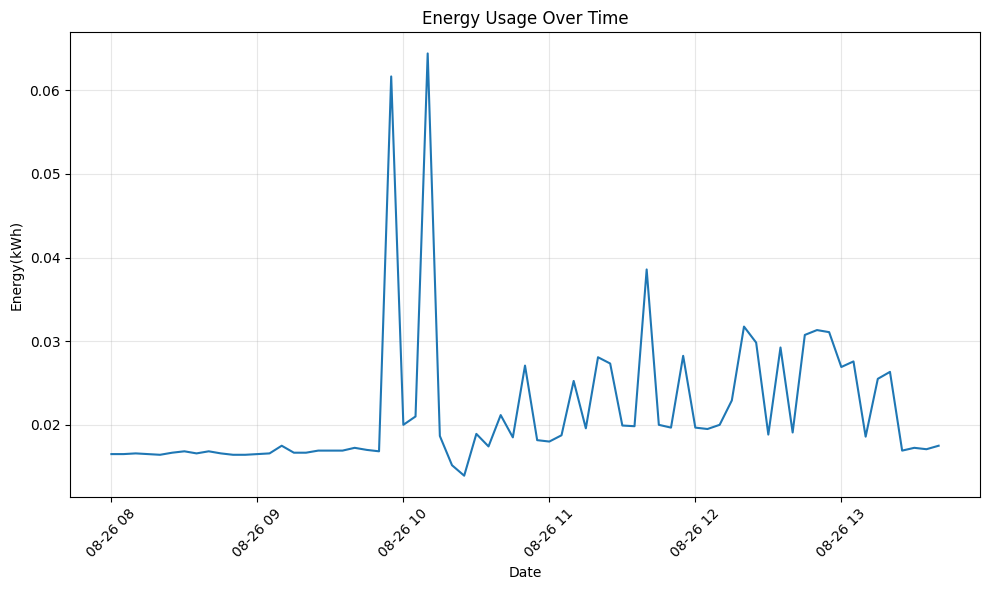

In [73]:
#raw_power_data.plot(x='Date', y='Energy(kWh)', title='Energy Usage Over Time')
start_time = '2025-08-26 08:00:00'
end_time = '2025-08-26 14:00:00'
plot_energy_usage(raw_power_data, x_col="Date", y_col="Energy(kWh)", title="Energy Usage Over Time", start=start_time, end=end_time)

In [ ]:
time_periods = [
    ("baseline", "2025-08-19 00:00:00", "2025-08-19 12:00:00"),
    ("trimming", "2025-08-26T09:09:44", "2025-08-19 13:00:00"),
    ("alignment", "2025-08-19 13:00:00", "2025-08-19 15:00:00"),
    ("mark-duplicates", "2025-08-19 15:00:00", "2025-08-19 21:00:00"),
    ("create-fasta-dict", "2025-08-19 21:00:00", "2025-08-20 00:00:00"),
    ("create-fasta-index", "2025-08-20 00:00:00", "2025-08-20 03:00:00"),
    ("base-quality-score", "2025-08-20 03:00:00", "2025-08-20 09:00:00")
]

In [ ]:
def compute_energy_stats(df, start_date, end_date):
    """
    Compute energy statistics between two timestamps.
    
    Parameters:
    df (pd.DataFrame): DataFrame with 'Date' and 'Energy(kWh)' columns
    start_date (str or pd.Timestamp): Start timestamp
    end_date (str or pd.Timestamp): End timestamp
    
    Returns:
    dict: Dictionary with energy statistics
    """
    # Convert string dates to datetime if needed
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Filter data between the two timestamps
    mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
    filtered_data = df.loc[mask]
    
    if filtered_data.empty:
        print(f"No data found between {start_date} and {end_date}")
        return {'total_energy': 0, 'avg_power': 0, 'max_power': 0, 'min_power': 0, 'filtered_data': 0}
    
    # Calculate statistics
    total_energy = filtered_data['Energy(kWh)'].sum()
    avg_power = filtered_data['Power(W)'].mean()
    max_power = filtered_data['Power(W)'].max()
    min_power = filtered_data['Power(W)'].min()
    
    return {
        'total_energy': total_energy,
        'avg_power': avg_power,
        'max_power': max_power,
        'min_power': min_power,
        'filtered_data': filtered_data
    }

def plot_energy_usage(df, x_col='Date', y_col='Energy(kWh)', title='Energy Usage Over Time', start=None, end=None):
    """
    Plot energy usage over time using matplotlib.pyplot
    
    Parameters:
    df (pd.DataFrame): DataFrame with date and energy columns
    x_col (str): Column name for x-axis (default: 'Date')
    y_col (str): Column name for y-axis (default: 'Energy(kWh)')
    title (str): Plot title
    """
    if start and end:
        copy = df[(df[x_col] >= start) & (df[x_col] <= end)]
    elif start:
        copy = df[df[x_col] >= start]
    elif end:
        copy = df[df[x_col] <= end]
    else:
        copy = df

    plt.figure(figsize=(10, 6))
    plt.plot(copy[x_col], copy[y_col])
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_energy_usage_overlay_multiple_datasets(raw_power_data, data_periods, time_periods_ct, start_time, end_time):
    """
    This plots the data as specified in plot_energy_usage and on top plots the multiple datasets as plot_multiple_datasets().
    """
    # Filter the raw data for the specified time range
    if start_time and end_time:
        filtered_raw = raw_power_data[(raw_power_data['Date'] >= start_time) & (raw_power_data['Date'] <= end_time)]
    elif start_time:
        filtered_raw = raw_power_data[raw_power_data['Date'] >= start_time]
    elif end_time:
        filtered_raw = raw_power_data[raw_power_data['Date'] <= end_time]
    else:
        filtered_raw = raw_power_data

    # Create single plot with both datasets
    plt.figure(figsize=(12, 6))
    
    # Plot the overall energy usage first (as background)
    plt.plot(filtered_raw['Date'], filtered_raw['Energy(kWh)'], 
             color='lightgray', alpha=0.7, linewidth=2, label='Overall Energy Usage')
    
    # Overlay the multiple datasets on the same plot
    for i, df in enumerate(data_periods):
        if not isinstance(df, pd.DataFrame):
            print(f"Dataset {i} is not a valid DataFrame.")
            continue
        # Use provided label or generate default
        if i < len(time_periods_ct):
            label = time_periods_ct[i][0]
        else:
            # Create label from date range
            start_date = df['Date'].min().strftime('%Y-%m-%d %H:%M')
            end_date = df['Date'].max().strftime('%Y-%m-%d %H:%M')
            label = f"Dataset {i+1}: {start_date} to {end_date}"
        
        plt.plot(df['Date'], df['Energy(kWh)'], label=label, marker='o', markersize=3)
    
    plt.xlabel('Date')
    plt.ylabel('Energy(kWh)')
    plt.title('Energy Usage Over Time with Multiple Datasets Overlay')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_multiple_datasets(datasets_list, labels=None, column='Power(W)', title=None):
    """
    Plot multiple filtered datasets as separate lines.
    
    Parameters:
    datasets_list (list): List of DataFrames (filtered_data from compute_energy_stats)
    labels (list): Optional list of labels for each dataset
    column (str): Column to plot ('Power(W)' or 'Energy(kWh)')
    title (str): Optional plot title
    """
    plt.figure(figsize=(12, 6))
    
    for i, df in enumerate(datasets_list):
        if df.empty:
            continue
            
        # Use provided label or generate default
        if labels and i < len(labels):
            label = labels[i]
        else:
            # Create label from date range
            start_date = df['Date'].min().strftime('%Y-%m-%d %H:%M')
            end_date = df['Date'].max().strftime('%Y-%m-%d %H:%M')
            label = f"Dataset {i+1}: {start_date} to {end_date}"
        
        plt.plot(df['Date'], df[column], label=label, marker='o', markersize=3)
    
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.title(title or f'{column} Over Time - Multiple Datasets')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Processing baseline...
start: 2025-08-26 01:00:00, end: 2025-08-26 08:00:00
Processing trimming...
start: 2025-08-26 09:09:44, end: 2025-08-26 09:29:00
Processing create-fasta-index...
start: 2025-08-26 09:29:10, end: 2025-08-26 09:30:06
Processing alignment...
start: 2025-08-26 09:30:16, end: 2025-08-26 10:39:59
Processing mark-duplicates...
start: 2025-08-26 10:40:09, end: 2025-08-26 11:04:28
Processing create-fasta-dict...
start: 2025-08-26 11:04:38, end: 2025-08-26 11:05:32
Processing base-quality-score...
start: 2025-08-26 11:05:42, end: 2025-08-26 11:07:52
No data found between 2025-08-26 11:05:42 and 2025-08-26 11:07:52


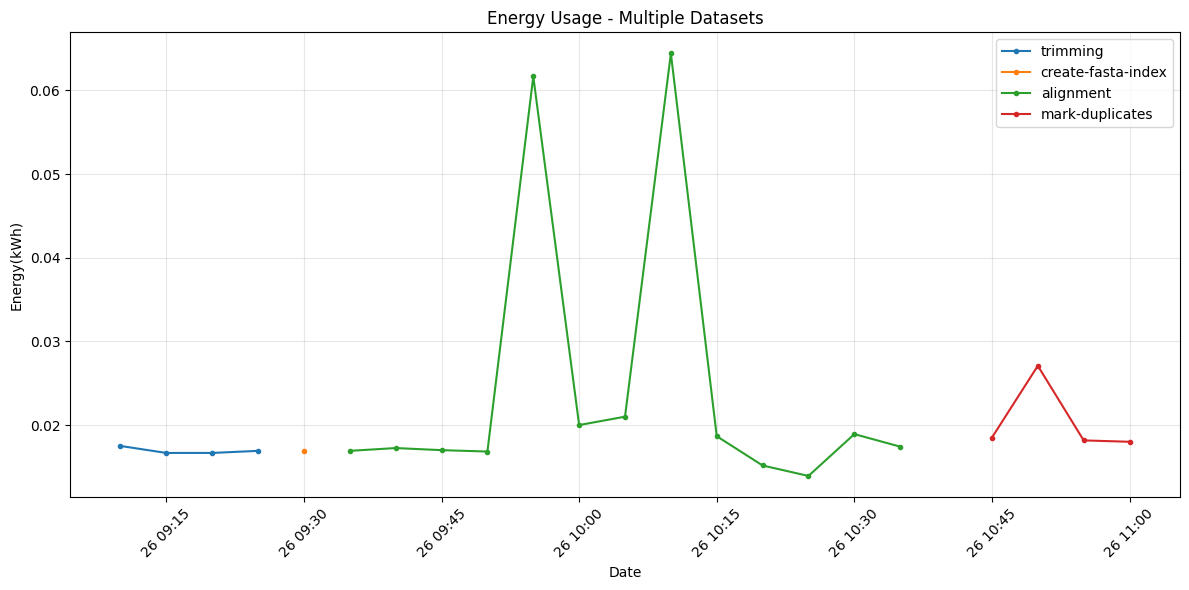

In [85]:
data_periods = []
for name, start, end in time_periods_ct:
    print(f"Processing {name}...")
    print(f"start: {start}, end: {end}")
    stats = compute_energy_stats(raw_power_data, start, end)
    #print(f"Energy stats for {name}: {stats}")
    data_periods.append(stats['filtered_data'])


# Plot multiple datasets
plot_multiple_datasets(data_periods[1:5], labels=[name for name, _, _ in time_periods_ct[1:5]], column='Energy(kWh)', title='Energy Usage - Multiple Datasets')

# get data from carbontracker results

path = "./data_carbontracker/conf-6/run1.dat"

ctd = carbontrackerdata

c6 = configuration 6 (conf-6)

r1 = run 1

In [17]:
path = "./data_carbontracker/conf-6/run1.dat"
ctd_c6_r1 = pd.read_csv(path, delim_whitespace=True, comment='#', header=0)

/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_79078/3199817076.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ctd_c6_r1 = pd.read_csv(path, delim_whitespace=True, comment='#', header=0)


In [18]:
ctd_c6_r1.head()

,step,start,stop,duration,co2,energy,status,output
0,trimming,2025-08-26T09:09:44Z,2025-08-26T09:29:00Z,1156,1.219,0.040536,Succeeded,trimming-results*
1,create-fasta-index,2025-08-26T09:29:10Z,2025-08-26T09:30:06Z,56,0.003,0.000086,Succeeded,fasta-index*
2,alignment,2025-08-26T09:30:16Z,2025-08-26T10:39:59Z,4183,6.607,0.219638,Succeeded,alignment-results*
3,mark-duplicates,2025-08-26T10:40:09Z,2025-08-26T11:04:28Z,1459,0.619,0.020589,Succeeded,mark-duplicates-results*
4,create-fasta-dict,2025-08-26T11:04:38Z,2025-08-26T11:05:32Z,54,0.006,0.000196,Succeeded,fasta-dict*


In [64]:
dt_format = '%Y-%m-%d %H:%M:%S'
time_periods_ct = []
time_periods_ct.append(('baseline', '2025-08-26 01:00:00', '2025-08-26 08:00:00'))
for _, row in ctd_c6_r1.iterrows():
    step_name = row['step']
    start_time = pd.to_datetime(row['start']).strftime(dt_format)
    stop_time = pd.to_datetime(row['stop']).strftime(dt_format)
    time_periods_ct.append((step_name, start_time, stop_time))

In [65]:
time_periods_ct

[('baseline', '2025-08-26 01:00:00', '2025-08-26 08:00:00'),
 ('trimming', '2025-08-26 09:09:44', '2025-08-26 09:29:00'),
 ('create-fasta-index', '2025-08-26 09:29:10', '2025-08-26 09:30:06'),
 ('alignment', '2025-08-26 09:30:16', '2025-08-26 10:39:59'),
 ('mark-duplicates', '2025-08-26 10:40:09', '2025-08-26 11:04:28'),
 ('create-fasta-dict', '2025-08-26 11:04:38', '2025-08-26 11:05:32'),
 ('base-quality-score', '2025-08-26 11:05:42', '2025-08-26 11:07:52')]

Dataset 6 is not a valid DataFrame.


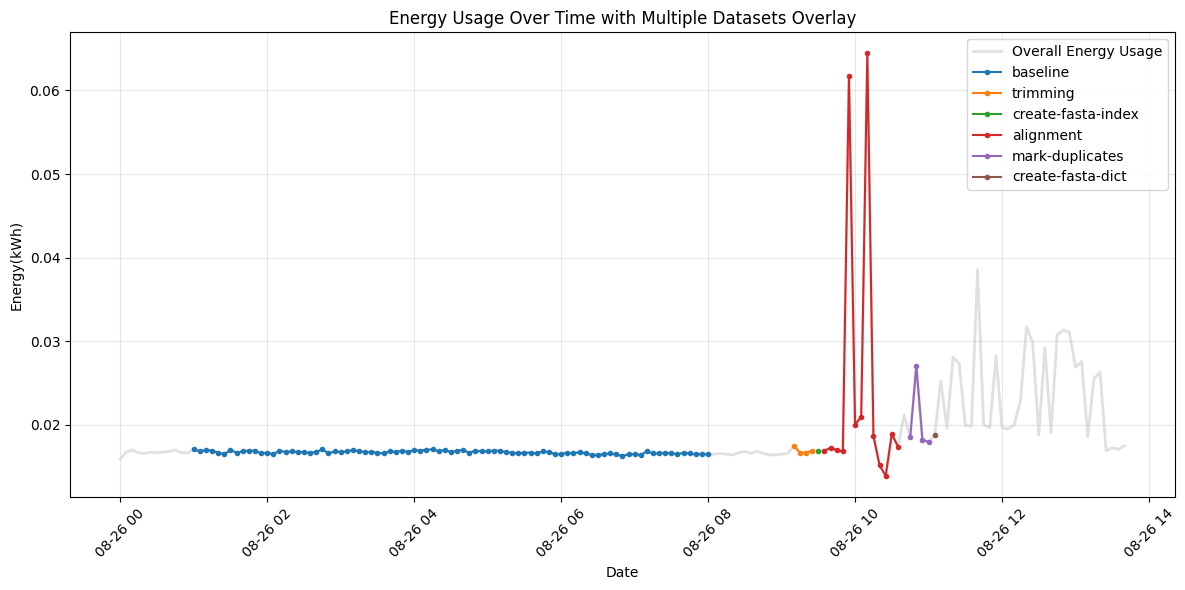

In [86]:
plot_energy_usage_overlay_multiple_datasets(raw_power_data, data_periods, time_periods_ct, start_time='2025-08-26 00:00:00', end_time='2025-08-26 23:59:59')

In [111]:
def compute_cumulative_energy_usage(time_periods_ct, data_periods):
    energy_usage = pd.DataFrame(columns=["step", "start", "stop", "Time(s)", "Energy(kWh)", "Power(W)"])

    step_energy = 0
    step_power = 0
    duration_seconds = 0

    for i, (step_name, start_time, stop_time) in enumerate(time_periods_ct):
        # Get the filtered data for this step
        print(f"Processing step: {step_name}; {start_time} - {stop_time}")
        if i < len(data_periods):
            filtered_data = data_periods[i]
            
            if isinstance(filtered_data, pd.DataFrame) and not filtered_data.empty:
                n_datapoints = filtered_data.shape[0]
                step_energy = filtered_data['Energy(kWh)'].sum() / n_datapoints
                step_power = filtered_data['Power(W)'].sum() / n_datapoints

                # Calculate duration of step in seconds
                start_dt = pd.to_datetime(start_time)
                stop_dt = pd.to_datetime(stop_time)
                duration_seconds = (stop_dt - start_dt).total_seconds()
            else:
                step_energy = 0
                step_power = 0
                duration_seconds = 0
        else:
            step_energy = 0
            step_power = 0
            duration_seconds = 0
        
        # Add row to energy_usage dataframe
        new_row = {
            'step': step_name,
            'start': start_time,
            'stop': stop_time,
            'Time(s)': duration_seconds,
            'Energy(kWh)': step_energy,
            'Power(W)': step_power
        }
        
        energy_usage = pd.concat([energy_usage, pd.DataFrame([new_row])], ignore_index=True)
    return energy_usage

def compute_relative_energy_usage(energy_usage_df):
    """
    Compute relative energy usage by subtracting baseline energy from all steps.
    
    Parameters:
    energy_usage_df (pd.DataFrame): Output from compute_cumulative_energy_usage()
    
    Returns:
    pd.DataFrame: DataFrame with baseline energy subtracted, excluding baseline step
    """
    # Get baselines
    baseline_energy = energy_usage_df.iloc[0]['Energy(kWh)']
    baseline_power = energy_usage_df.iloc[0]['Power(W)']

    # Create copy excluding baseline step
    relative_df = energy_usage_df.iloc[1:].copy()
    
    # Subtract baseline energy from cumulative energy
    relative_df['Time(s)'] = relative_df['Time(s)']
    relative_df['Energy(kWh)'] = relative_df['Energy(kWh)'] - baseline_energy
    relative_df['Power(W)'] = relative_df['Power(W)'] - baseline_power

    return relative_df


In [112]:
energy_usage = compute_cumulative_energy_usage(time_periods_ct, data_periods)
energy_usage

Processing step: baseline; 2025-08-26 01:00:00 - 2025-08-26 08:00:00
Processing step: trimming; 2025-08-26 09:09:44 - 2025-08-26 09:29:00
Processing step: create-fasta-index; 2025-08-26 09:29:10 - 2025-08-26 09:30:06
Processing step: alignment; 2025-08-26 09:30:16 - 2025-08-26 10:39:59
Processing step: mark-duplicates; 2025-08-26 10:40:09 - 2025-08-26 11:04:28
Processing step: create-fasta-dict; 2025-08-26 11:04:38 - 2025-08-26 11:05:32
Processing step: base-quality-score; 2025-08-26 11:05:42 - 2025-08-26 11:07:52


/var/folders/9x/df97rq2j35gg_bpq8dzj7wz40000gn/T/ipykernel_79078/1044420607.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  energy_usage = pd.concat([energy_usage, pd.DataFrame([new_row])], ignore_index=True)


,step,start,stop,Time(s),Energy(kWh),Power(W)
0,baseline,2025-08-26 01:00:00,2025-08-26 08:00:00,25200.0,0.016725,200.705882
1,trimming,2025-08-26 09:09:44,2025-08-26 09:29:00,1156.0,0.016937,203.250000
2,create-fasta-index,2025-08-26 09:29:10,2025-08-26 09:30:06,56.0,0.016917,203.000000
3,alignment,2025-08-26 09:30:16,2025-08-26 10:39:59,4183.0,0.024551,294.615385
4,mark-duplicates,2025-08-26 10:40:09,2025-08-26 11:04:28,1459.0,0.020438,245.250000
5,create-fasta-dict,2025-08-26 11:04:38,2025-08-26 11:05:32,54.0,0.018750,225.000000
6,base-quality-score,2025-08-26 11:05:42,2025-08-26 11:07:52,0.0,0.000000,0.000000


In [113]:
compute_relative_energy_usage(energy_usage)

,step,start,stop,Time(s),Energy(kWh),Power(W)
1,trimming,2025-08-26 09:09:44,2025-08-26 09:29:00,1156.0,0.000212,2.544118
2,create-fasta-index,2025-08-26 09:29:10,2025-08-26 09:30:06,56.0,0.000191,2.294118
3,alignment,2025-08-26 09:30:16,2025-08-26 10:39:59,4183.0,0.007826,93.909502
4,mark-duplicates,2025-08-26 10:40:09,2025-08-26 11:04:28,1459.0,0.003712,44.544118
5,create-fasta-dict,2025-08-26 11:04:38,2025-08-26 11:05:32,54.0,0.002025,24.294118
6,base-quality-score,2025-08-26 11:05:42,2025-08-26 11:07:52,0.0,-0.016725,-200.705882


In [99]:
ctd_c6_r1

,step,start,stop,duration,co2,energy,status,output
0,trimming,2025-08-26T09:09:44Z,2025-08-26T09:29:00Z,1156,1.219,0.040536,Succeeded,trimming-results*
1,create-fasta-index,2025-08-26T09:29:10Z,2025-08-26T09:30:06Z,56,0.003,0.000086,Succeeded,fasta-index*
2,alignment,2025-08-26T09:30:16Z,2025-08-26T10:39:59Z,4183,6.607,0.219638,Succeeded,alignment-results*
3,mark-duplicates,2025-08-26T10:40:09Z,2025-08-26T11:04:28Z,1459,0.619,0.020589,Succeeded,mark-duplicates-results*
4,create-fasta-dict,2025-08-26T11:04:38Z,2025-08-26T11:05:32Z,54,0.006,0.000196,Succeeded,fasta-dict*
5,base-quality-score,2025-08-26T11:05:42Z,2025-08-26T11:07:52Z,130,0.005,0.000175,Succeeded,final-results*
